# 🏁 Formula 1 Race Analysis with Python
### 2021 Abu Dhabi Grand Prix — Consistency & Strategy Study

This notebook is part of the **f1-analyst-with-python** project, whose goal is to explore real Formula 1 race data through data-science tooling.

In this study we dive into the controversial 2021 Abu Dhabi Grand Prix focusing on:

- **Driver consistency** (per-lap time standard deviation)
- **Position evolution over the race**
- **Pit stop strategies** (undercut vs. overcut) *(planned / partial)*
- **Key race-defining events**

Our goal is to provide an analytical view over the key moments that shaped the race outcome, written clearly and professionally for engineers and data scientists.


### 1. Setup & Reproducibility

In [1]:

# Core
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Project
from f1_race_analysis_with_python.config.constants import DATA_DIR
from f1_race_analysis_with_python.script.Lap_Times_Consistency import plot_lap_times_consistency
from f1_race_analysis_with_python.script.Drivers_Positions import plot_drivers_positions
from f1_race_analysis_with_python.script.Plot_Pit_strategies import detect_pit_strategies

# Plot defaults
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.grid": True,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})
sns.set(style="whitegrid")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


### 2. Data Loading

In [2]:

# Expected CSVs (or Parquet) inside DATA_DIR
races = pd.read_csv(DATA_DIR / "races.csv")
drivers = pd.read_csv(DATA_DIR / "drivers.csv")
lap_times = pd.read_csv(DATA_DIR / "lap_times.csv")
pit_stops = pd.read_csv(DATA_DIR / "pit_stops.csv")

display(races.head())
display(drivers.head())
display(lap_times.head())
display(pit_stops.head())


,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


### 3. Data Sanity Checks

Before running any analysis, let's ensure key columns exist, data types are sane, and we have no obvious data quality issues (e.g., duplicated laps).


In [3]:

def check_required_columns(df, required, name):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in {name}: {missing}")

check_required_columns(lap_times, ["raceId", "driverId", "lap", "milliseconds"], "lap_times")
check_required_columns(pit_stops, ["raceId", "driverId", "lap", "duration"], "pit_stops")

print("Rows per table:")
for name, df in {"races": races, "drivers": drivers, "lap_times": lap_times, "pit_stops": pit_stops}.items():
    print(f"- {name}: {len(df):,} rows")

# Remove duplicated lap entries if any
laps = lap_times.drop_duplicates(subset=["raceId", "driverId", "lap"])


Rows per table:
- races: 1,125 rows
- drivers: 861 rows
- lap_times: 589,081 rows
- pit_stops: 11,371 rows


## 4. Driver Consistency

**Goal:** quantify how consistent each driver was along the race (and optionally per stint), using the **standard deviation of lap times** (in seconds). Lower standard deviation = more consistent pace.

We will:
1. Convert milliseconds to seconds.
2. Optionally remove in-/out-laps (first lap after pit, lap before pit) and safety car laps.
3. Compute per-driver standard deviation.


In [4]:

laps["lap_time_s"] = laps["milliseconds"] / 1000.0

# Example: filter only the target race
race_name = "Abu Dhabi Grand Prix"
race_id = races.loc[races["name"].str.contains("Abu Dhabi", case=False), "raceId"].iloc[0]

laps_race = laps.query("raceId == @race_id").copy()
pitstops_race = pit_stops.query("raceId == @race_id").copy()

# (Optional) Drop in- and out-laps:
# This requires mapping pitstop laps per driver — keeping it simple with a helper
def mark_in_out_laps(laps_df, pit_df):
    in_out = set()
    for _, row in pit_df.iterrows():
        d, lap = row["driverId"], row["lap"]
        in_out.update([(d, lap), (d, lap + 1)])
    mask = laps_df.apply(lambda r: (r["driverId"], r["lap"]) in in_out, axis=1)
    return mask

laps_race["is_in_out"] = mark_in_out_laps(laps_race, pitstops_race)
clean_laps_race = laps_race.loc[~laps_race["is_in_out"]].copy()

driver_std = (
    clean_laps_race.groupby("driverId")["lap_time_s"]
    .std()
    .rename("std_lap_time_s")
    .sort_values()
    .reset_index()
    .merge(drivers[["driverId", "code", "surname"]], on="driverId", how="left")
)

display(driver_std.head(10))


,driverId,std_lap_time_s,code,surname
0,4,4.368450,ALO,Alonso
1,5,4.447098,KOV,Kovalainen
2,6,4.483807,NAK,Nakajima
3,155,4.517385,KOB,Kobayashi
4,8,4.552132,RAI,Räikkönen
5,154,4.578991,GRO,Grosjean
6,24,4.664367,LIU,Liuzzi
7,21,5.000805,FIS,Fisichella
8,20,5.115739,VET,Vettel
9,17,5.178973,WEB,Webber


#### 4.1 Ranking by (lower) lap-time standard deviation

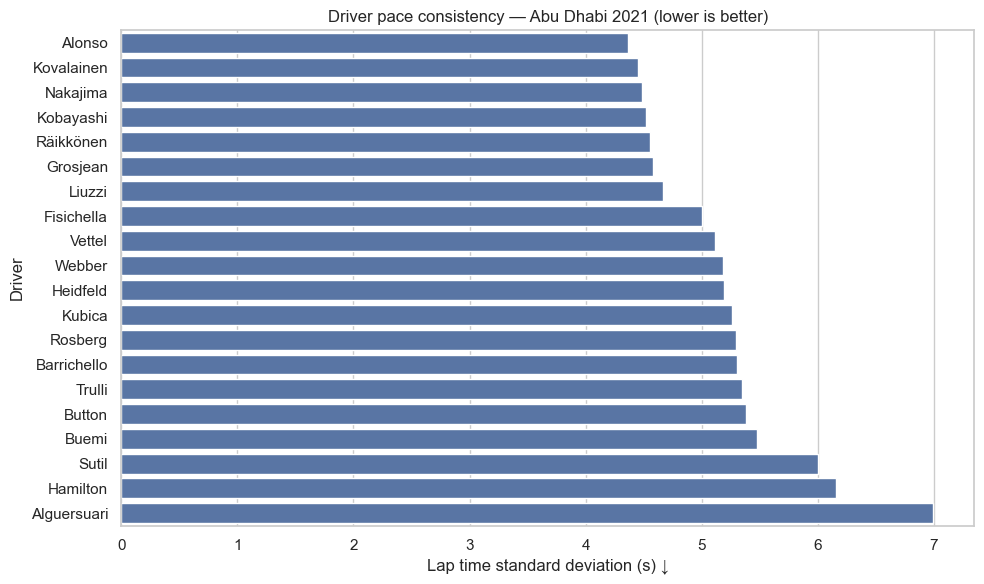

In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    data=driver_std.sort_values("std_lap_time_s"),
    x="std_lap_time_s",
    y="surname",
    ax=ax
)
ax.set_xlabel("Lap time standard deviation (s) ↓")
ax.set_ylabel("Driver")
ax.set_title("Driver pace consistency — Abu Dhabi 2021 (lower is better)")
plt.tight_layout()
plt.show()


## 5. Position Evolution per Lap

Visualize how each driver's position evolved throughout the race. This is especially useful to highlight **key overtakes, safety car periods** and race control decisions.


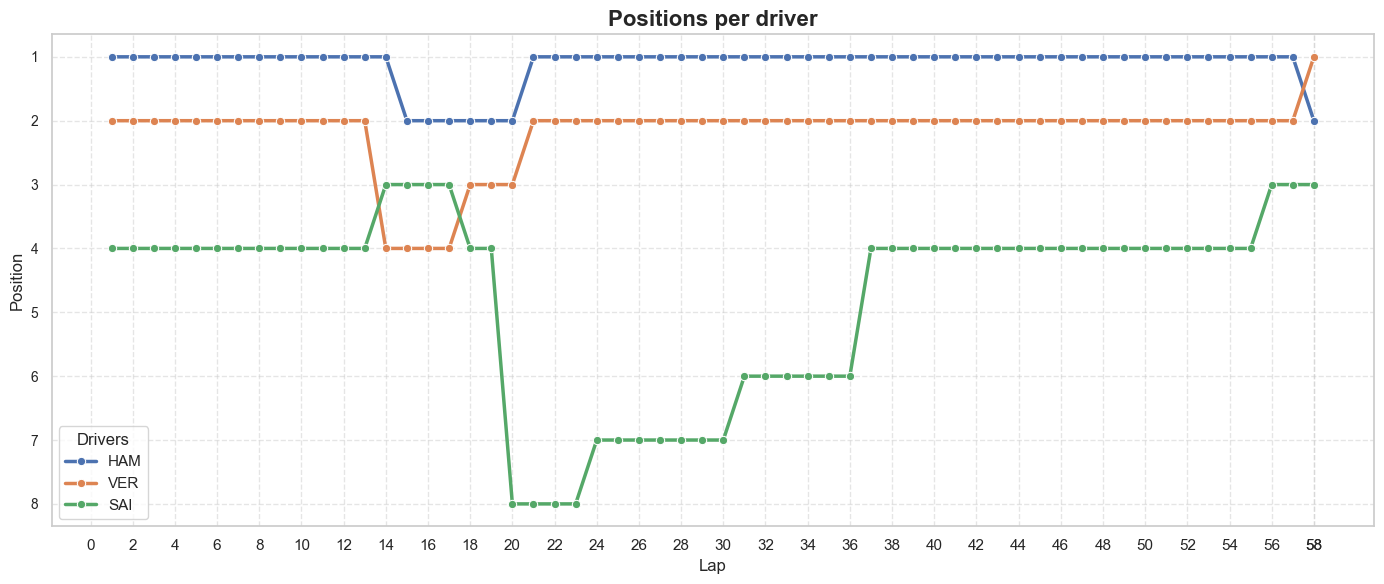

In [6]:

plot_drivers_positions(["HAM", "VER", "SAI"])


## 6. Pit Stop Strategy: Undercut vs Overcut

We classify each pit stop into **undercut** (pitting earlier and gaining time/track position after the opponent pits later) or **overcut** (staying out longer and still gaining).

**Method (simplified):**
1. For each pair of drivers that pit around the same race window, we compute their relative delta before and after the pit stop.
2. If the earlier stopper gains on the later stopper ⇒ **undercut**.
3. If the later stopper gains on the earlier ⇒ **overcut**.


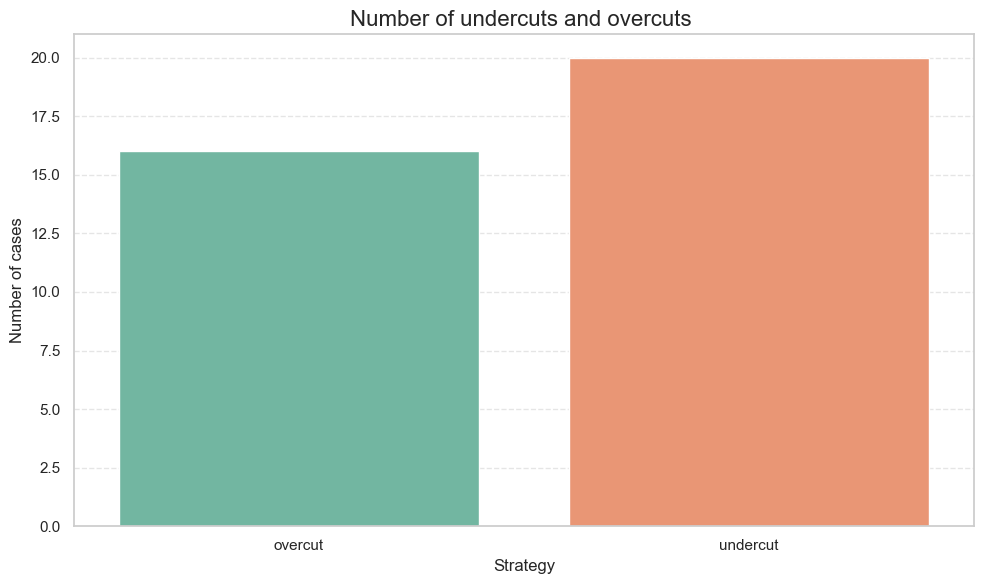

In [7]:
detect_pit_strategies(lap_times, pit_stops, drivers, race_id=1073)


## 7. Key Events Timeline (Optional)

If you maintain a manually curated or parsed list of key race events (safety cars, VSCs, accidents, penalties), integrate them here so the plots above can be annotated accordingly.

> **Idea:** build a helper that takes a list of events with `lap`, `type`, `description` and overlays them on the position evolution chart.


## 8. Conclusions & Next Steps

**What we found (placeholders — replace with your actual findings):**
- The most consistent driver by lap-time std. dev. was `XYZ`, indicating a very stable pace across stints.
- The position evolution reveals a decisive moment on lap **N**, aligning with the Safety Car deployment.
- We detected a slightly higher number of **undercuts** than **overcuts**, but both strategies appear meaningful.

---


## 9. Thank You & Acknowledgments

Thank you for reviewing this analysis. We hope these insights contribute to deeper strategic understanding and future performance gains. Please feel free to reach out with questions, feedback, or ideas for further exploration.

---

*Prepared by Gabryel Januario*
